# Survival analysis with sklearn, glmnet, keras, pytorch, lightgbm, xgboost, nnetsauce, mlsauce

<a target="_blank" href="https://colab.research.google.com/github/Techtonique/survivalist/blob/main/survivalist/demo/2024-12-15-survivalist-sklearn-pytorch-keras-nnetsauce.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!pip uninstall -y survivalist

In [ ]:
!pip install survivalist --upgrade --no-cache-dir

In [ ]:
!pip install glmnetforpython --verbose --upgrade --no-cache-dir

In [ ]:
!pip install nnetsauce --verbose --upgrade --no-cache-dir

In [ ]:
!pip install scikeras

In [ ]:
!pip install xgboost --upgrade --no-cache-dir
!pip install lightgbm --upgrade --no-cache-dir

In [ ]:
!pip install git+https://github.com/Techtonique/mlsauce.git --verbose

In [8]:
import numpy as np

In [9]:
import pandas as pd

def _encode_categorical_columns(df, categorical_columns=None):
    """
    Automatically identifies categorical columns and applies one-hot encoding.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with mixed continuous and categorical variables.
    - categorical_columns (list): Optional list of column names to treat as categorical.

    Returns:
    - pd.DataFrame: A new DataFrame with one-hot encoded categorical columns.
    """
    # Automatically identify categorical columns if not provided
    if categorical_columns is None:
        categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Apply one-hot encoding to the identified categorical columns
    df_encoded = pd.get_dummies(df, columns=categorical_columns)

    # Convert boolean columns to integer (0 and 1)
    bool_columns = df_encoded.select_dtypes(include=['bool']).columns.tolist()
    df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)

    return df_encoded


In [10]:
import matplotlib.pyplot as plt
import nnetsauce as ns
import glmnetforpython as glmnet
from survivalist.nonparametric import kaplan_meier_estimator
from survivalist.datasets import load_whas500, load_gbsg2, load_veterans_lung_cancer
from survivalist.ensemble import ComponentwiseGenGradientBoostingSurvivalAnalysis
from survivalist.custom import SurvivalCustom
from survivalist.custom import PISurvivalCustom
from survivalist.ensemble import GradientBoostingSurvivalAnalysis
from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from survivalist.ensemble import PIComponentwiseGenGradientBoostingSurvivalAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from time import time

import matplotlib.pyplot as plt
import nnetsauce as ns
import numpy as np
from survivalist.datasets import load_whas500, load_veterans_lung_cancer, load_gbsg2
from survivalist.custom import SurvivalCustom
from sklearn.linear_model import BayesianRidge, ARDRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from survivalist.metrics import brier_score, integrated_brier_score
from time import time

import pandas as pd

# 1 - using `scikit-learn` with conformal prediction

100%|██████████| 100/100 [00:06<00:00, 15.72it/s]


Time to fit PIRandomForestRegressor:  12.00599455833435


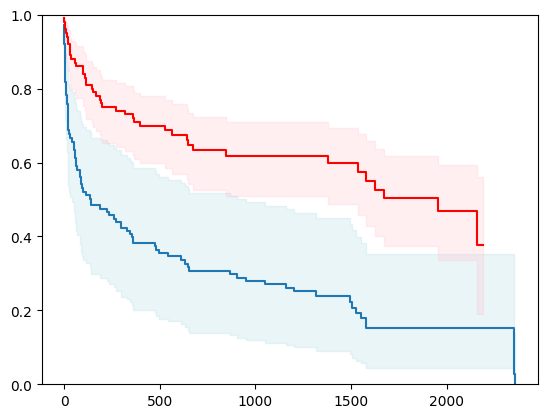

In [11]:
X, y = load_whas500()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PIComponentwiseGenGradientBoostingSurvivalAnalysis(regr=RidgeCV(), type_pi="bootstrap")

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

100%|██████████| 100/100 [00:02<00:00, 34.04it/s]


Time to fit PIRandomForestRegressor:  6.0161802768707275


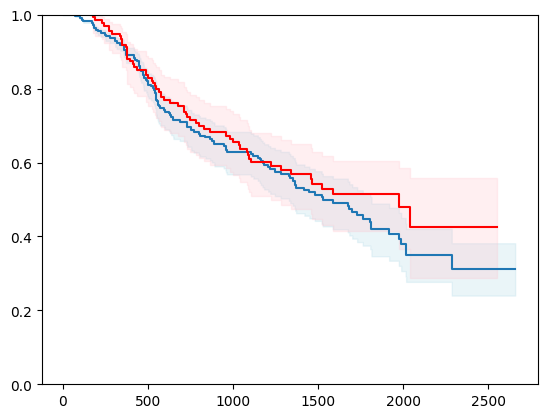

In [12]:
X, y = load_gbsg2()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PIComponentwiseGenGradientBoostingSurvivalAnalysis(regr=RidgeCV(), type_pi="kde")

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])


for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

100%|██████████| 100/100 [00:03<00:00, 28.76it/s]


Time to fit PIRandomForestRegressor:  6.117877721786499


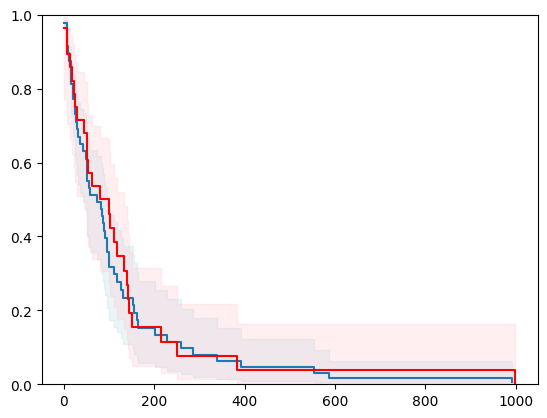

In [13]:
X, y = load_veterans_lung_cancer()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PIComponentwiseGenGradientBoostingSurvivalAnalysis(regr=RidgeCV(), type_pi="kde")

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

100%|██████████| 100/100 [00:02<00:00, 40.38it/s]


Time to fit PIRandomForestRegressor:  5.103362798690796


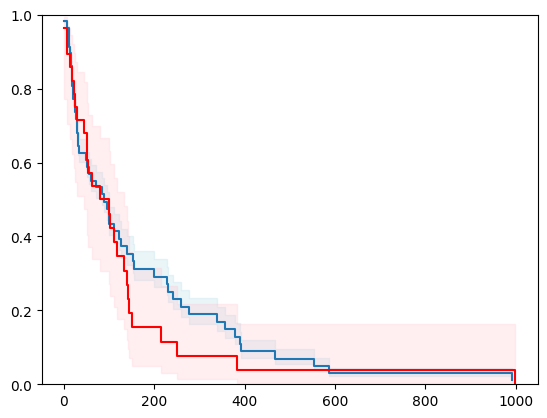

In [14]:
X, y = load_veterans_lung_cancer()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PIComponentwiseGenGradientBoostingSurvivalAnalysis(regr=RidgeCV(), type_pi="ecdf")

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

100%|██████████| 100/100 [00:03<00:00, 32.68it/s]


Time to fit PIRandomForestRegressor:  5.761382341384888


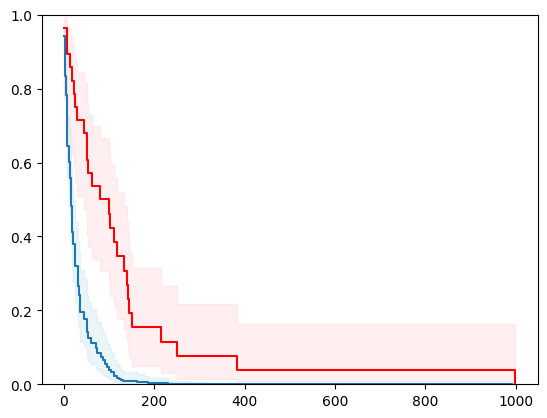

In [15]:
X, y = load_veterans_lung_cancer()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PIComponentwiseGenGradientBoostingSurvivalAnalysis(regr=RidgeCV(), type_pi="kde")

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

# 2 - using `nnetsauce`

## 2 - 1 with conformal prediction

100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Time to fit PIRandomForestRegressor:  102.93466806411743


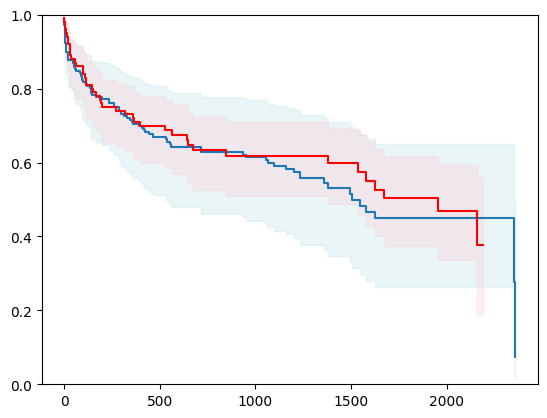

In [16]:
X, y = load_whas500()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PIComponentwiseGenGradientBoostingSurvivalAnalysis(regr=ns.CustomRegressor(RidgeCV()),
                                                               type_pi="bootstrap")

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

Time to fit PIRandomForestRegressor:  1.0441734790802002


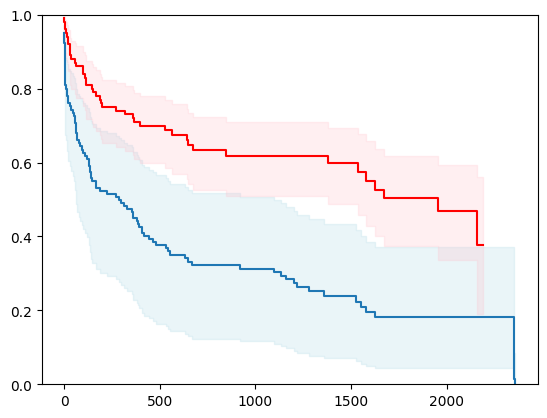

In [17]:
from pickle import Pickler
X, y = load_whas500()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PISurvivalCustom(regr=ns.CustomRegressor(RidgeCV()), type_pi="kde")

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


Time to fit PIRandomForestRegressor:  54.04567575454712


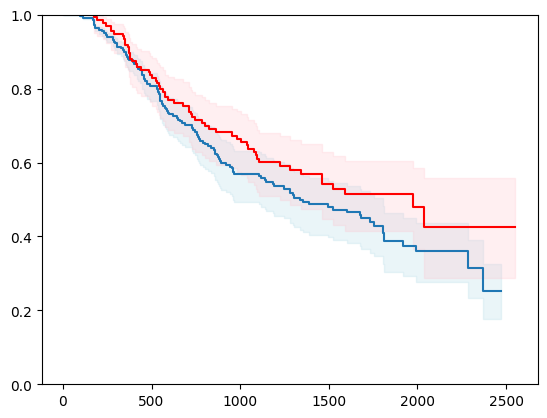

In [18]:
X, y = load_gbsg2()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PIComponentwiseGenGradientBoostingSurvivalAnalysis(regr=ns.CustomRegressor(RidgeCV()),
                                                               type_pi="kde")

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])


for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

100%|██████████| 100/100 [00:21<00:00,  4.60it/s]


Time to fit PIRandomForestRegressor:  47.5219292640686


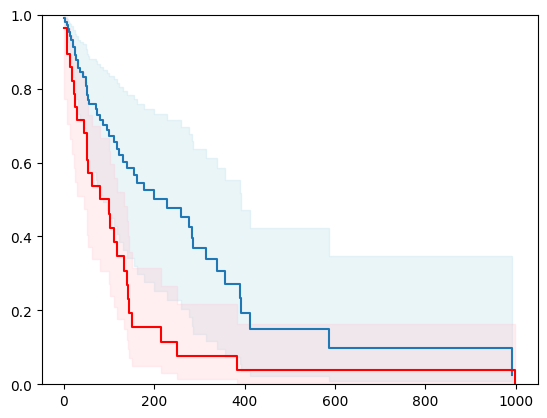

In [19]:
X, y = load_veterans_lung_cancer()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PIComponentwiseGenGradientBoostingSurvivalAnalysis(regr=ns.CustomRegressor(RidgeCV()),
                                                               type_pi="kde")

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

Time to fit PIRandomForestRegressor:  4.612172603607178


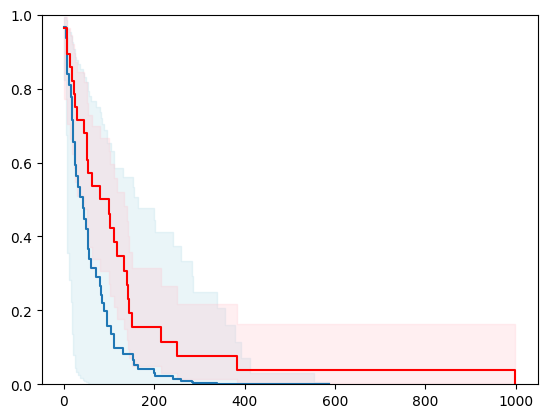

In [20]:
X, y = load_veterans_lung_cancer()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PISurvivalCustom(regr=ns.CustomRegressor(RandomForestRegressor()),
                             type_pi="bootstrap")

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


Time to fit PIRandomForestRegressor:  41.82555031776428


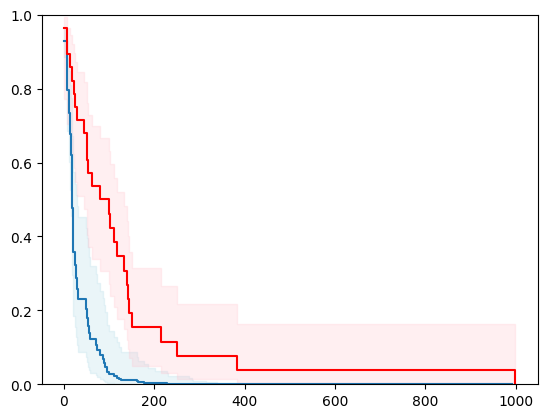

In [21]:
X, y = load_veterans_lung_cancer()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PIComponentwiseGenGradientBoostingSurvivalAnalysis(regr=ns.CustomRegressor(RidgeCV()),
                                                               type_pi="ecdf")

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

Time to fit PIRandomForestRegressor:  5.2234907150268555


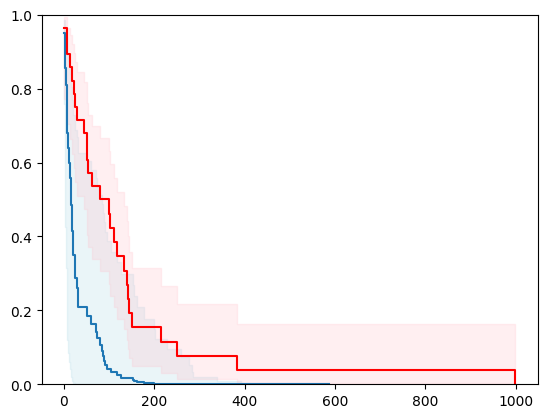

In [22]:
X, y = load_veterans_lung_cancer()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PISurvivalCustom(regr=ns.CustomRegressor(RandomForestRegressor()),
                             type_pi="ecdf")

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


Time to fit PIRandomForestRegressor:  41.465712547302246


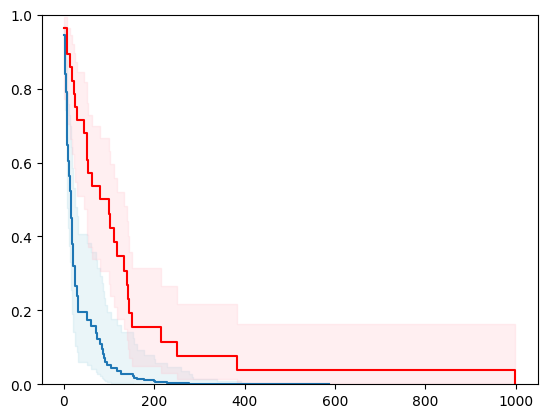

In [23]:
X, y = load_veterans_lung_cancer()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PIComponentwiseGenGradientBoostingSurvivalAnalysis(regr=ns.CustomRegressor(RidgeCV()),
                                                               type_pi="kde")

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

## 2 - 2 with Bayesian Inference

In [24]:


def encode_categorical_columns(df, categorical_columns=None):
    """
    Automatically identifies categorical columns and applies one-hot encoding.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with mixed continuous and categorical variables.
    - categorical_columns (list): Optional list of column names to treat as categorical.

    Returns:
    - pd.DataFrame: A new DataFrame with one-hot encoded categorical columns.
    """
    # Automatically identify categorical columns if not provided
    if categorical_columns is None:
        categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Apply one-hot encoding to the identified categorical columns
    df_encoded = pd.get_dummies(df, columns=categorical_columns)

    # Convert boolean columns to integer (0 and 1)
    bool_columns = df_encoded.select_dtypes(include=['bool']).columns.tolist()
    df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)

    return df_encoded


X, y = load_veterans_lung_cancer()
X = encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.4,
                                                    random_state=42)

print("\n\n BayesianRidge ------------------")

estimator = SurvivalCustom(regr=ns.CustomRegressor(BayesianRidge()))
estimator2 = SurvivalCustom(regr=ns.CustomRegressor(GaussianProcessRegressor()))
estimator3 = SurvivalCustom(regr=ns.CustomRegressor(ARDRegression()))

start = time()
estimator.fit(X_train, y_train)
print("Time to fit BayesianRidge: ", time() - start)
start = time()
estimator2.fit(X_train, y_train)
print("Time to fit GaussianProcessRegressor: ", time() - start)
start = time()
estimator3.fit(X_train, y_train)
print("Time to fit ARDRegression: ", time() - start)


surv_funcs = estimator.predict_survival_function(X_test.iloc[0:1,:], return_std=True)
surv_funcs2 = estimator2.predict_survival_function(X_test.iloc[0:1,:], return_std=True)
surv_funcs3 = estimator3.predict_survival_function(X_test.iloc[0:1,:], return_std=True)



 BayesianRidge ------------------
Time to fit BayesianRidge:  0.22817230224609375
Time to fit GaussianProcessRegressor:  0.47516417503356934
Time to fit ARDRegression:  0.5231645107269287


In [25]:
event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")


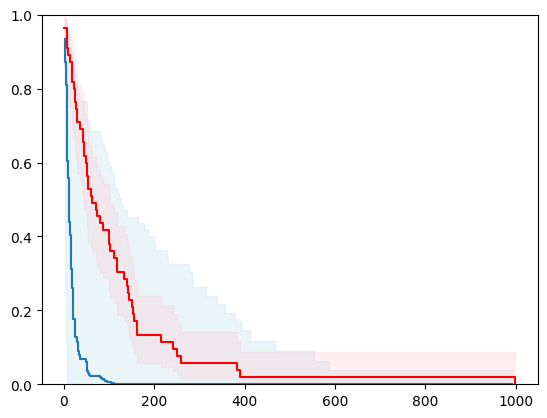

In [26]:
for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

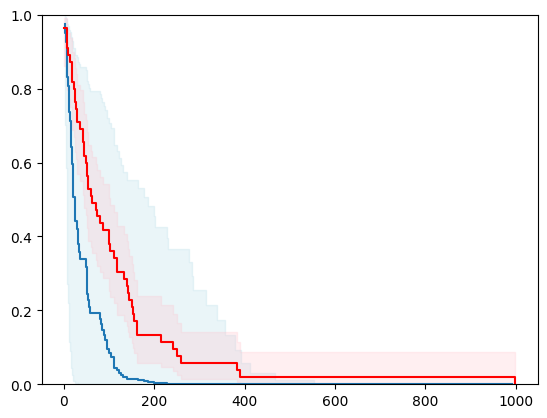

In [27]:
for fn in surv_funcs2.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs2.lower[0].y, surv_funcs2.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

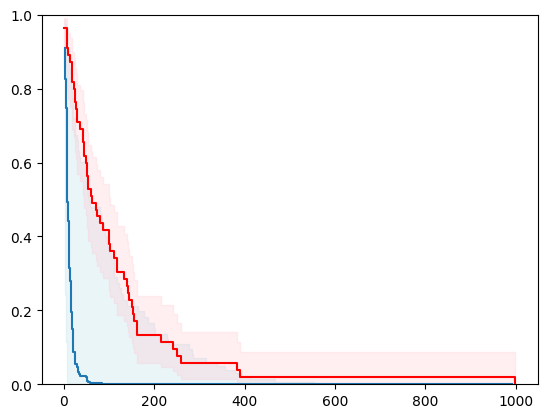

In [28]:
for fn in surv_funcs3.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs3.lower[0].y, surv_funcs3.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

# 3 - using `glmnet`

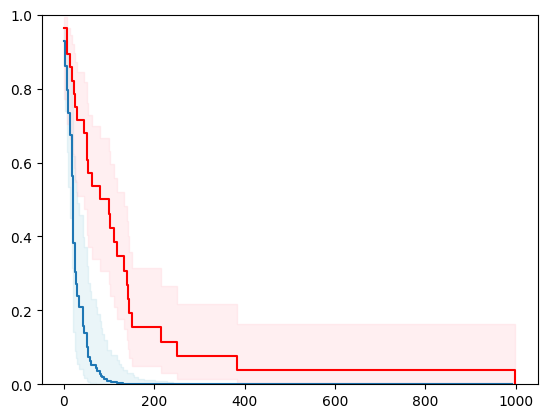

In [29]:
X, y = load_veterans_lung_cancer()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PISurvivalCustom(regr=ns.CustomRegressor(glmnet.GLMNet(lambdau=1000)),
                             type_pi="bootstrap")

estimator.fit(X_train, y_train)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


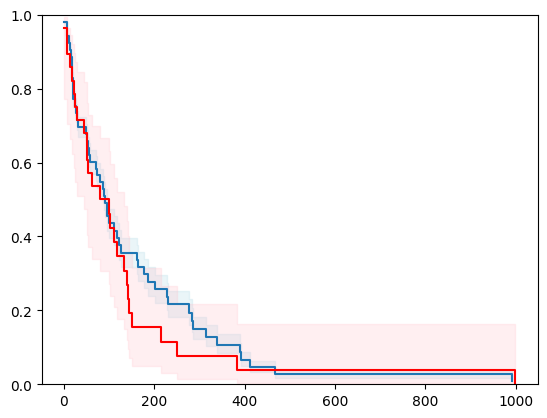

In [30]:
estimator = PIComponentwiseGenGradientBoostingSurvivalAnalysis(regr=ns.CustomRegressor(glmnet.GLMNet(lambdau=1000)),
                             type_pi="kde")

estimator.fit(X_train, y_train)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

# 4 - using `pytorch`

In [31]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin

class MLPRegressorTorch(BaseEstimator, RegressorMixin):
    def __init__(self, input_size=1, hidden_sizes=(64, 32), activation=nn.ReLU,
                 learning_rate=0.001, max_epochs=100, batch_size=32, random_state=None):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.random_state = random_state

        if self.random_state is not None:
            torch.manual_seed(self.random_state)

    def _build_model(self):
        layers = []
        input_dim = self.input_size

        for hidden_size in self.hidden_sizes:
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(self.activation())
            input_dim = hidden_size

        layers.append(nn.Linear(input_dim, 1))  # Output layer
        self.model = nn.Sequential(*layers)

    def fit(self, X, y, sample_weight=None):

        if sample_weight is not None:
            sample_weight = torch.tensor(sample_weight, dtype=torch.float32)

        X, y = self._prepare_data(X, y)
        self._build_model()

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

        dataset = torch.utils.data.TensorDataset(X, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        self.model.train()
        for epoch in range(self.max_epochs):
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = self.model(batch_X).squeeze()
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        return self

    def predict(self, X):
        X = self._prepare_data(X)
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X).squeeze()
        return predictions.numpy()

    def _prepare_data(self, X, y=None):
        if isinstance(X, np.ndarray):
            X = torch.tensor(X, dtype=torch.float32)
        if y is not None:
            if isinstance(y, np.ndarray):
                y = torch.tensor(y, dtype=torch.float32)
            return X, y
        return X

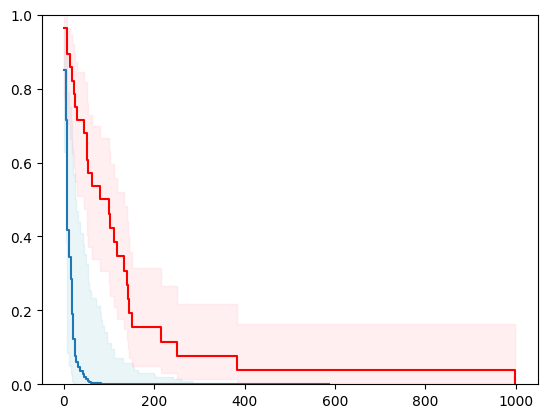

In [32]:
X, y = load_veterans_lung_cancer()
X = _encode_categorical_columns(X)

# Create a new structured array with Survival_in_days as float32
new_dtype = [('Status', '?'), ('Survival_in_days', '<f4')]
y_converted = np.array(y.tolist(), dtype=new_dtype)

X_train, X_test, y_train, y_test = train_test_split(X, y_converted,
                                                    test_size=0.2,
                                                    random_state=42)
# Convert X_train and X_test to float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PISurvivalCustom(regr=MLPRegressorTorch(input_size=X_train.shape[1]+1,
                                                    hidden_sizes=(20, 20, 20),
                                                    max_epochs=200,
                                                    random_state=42),
                             type_pi="ecdf")

estimator.fit(X_train, y_train)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

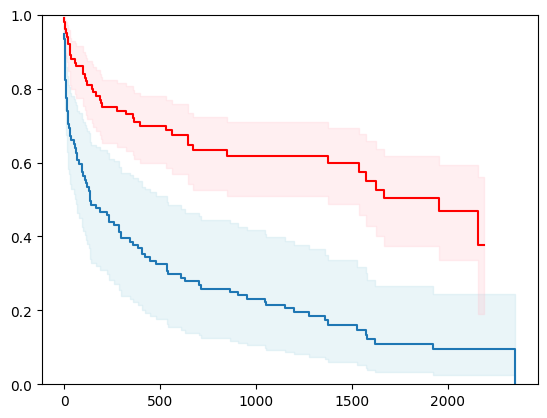

In [33]:
X, y = load_whas500()
X = _encode_categorical_columns(X)

# Create a new structured array with Survival_in_days as float32
new_dtype = [('Status', '?'), ('Survival_in_days', '<f4')]
y_converted = np.array(y.tolist(), dtype=new_dtype)

X_train, X_test, y_train, y_test = train_test_split(X, y_converted,
                                                    test_size=0.2,
                                                    random_state=42)
# Convert X_train and X_test to float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PISurvivalCustom(regr=MLPRegressorTorch(input_size=X_train.shape[1]+1,
                                                    hidden_sizes=(20, 20, 20),
                                                    max_epochs=200,
                                                    random_state=42),
                             type_pi="ecdf")

estimator.fit(X_train, y_train)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

# 5 - Using keras (through `scikeras`)

In [34]:
import keras
import keras.models
from scikeras.wrappers import KerasRegressor


def get_reg(meta, hidden_layer_sizes, dropout):
    n_features_in_ = meta["n_features_in_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation="relu"))
        model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(1))
    return model

reg = KerasRegressor(
    model=get_reg,
    loss="mse",
    metrics=[keras.metrics.R2Score],
    hidden_layer_sizes=(20, 20, 20),
    dropout=0.1,
    verbose=0,
    random_state=123
)

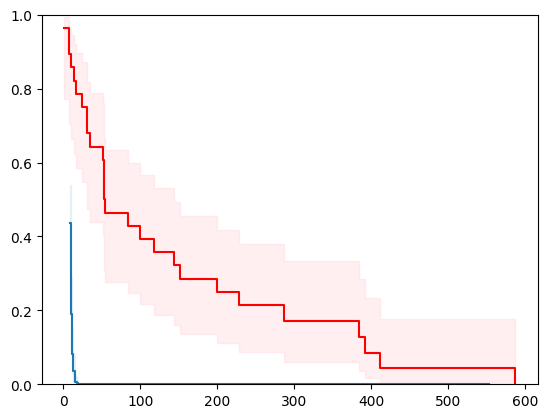

In [35]:
X, y = load_veterans_lung_cancer()
X = _encode_categorical_columns(X)

# Create a new structured array with Survival_in_days as float32
new_dtype = [('Status', '?'), ('Survival_in_days', '<f4')]
y_converted = np.array(y.tolist(), dtype=new_dtype)

X_train, X_test, y_train, y_test = train_test_split(X, y_converted,
                                                    test_size=0.2,
                                                    random_state=4)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PISurvivalCustom(regr=reg,
                             type_pi="kde")

estimator.fit(X_train, y_train)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

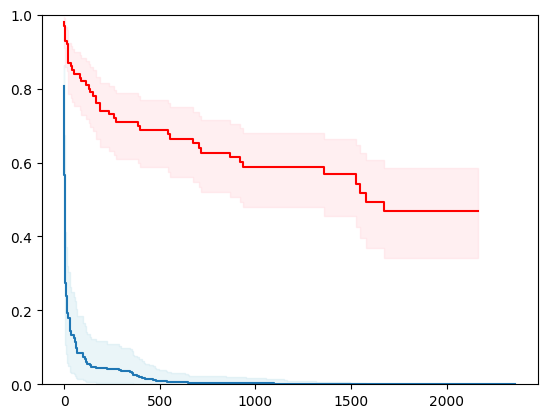

In [36]:
X, y = load_whas500()
X = _encode_categorical_columns(X)

# Create a new structured array with Survival_in_days as float32
new_dtype = [('Status', '?'), ('Survival_in_days', '<f4')]
y_converted = np.array(y.tolist(), dtype=new_dtype)

X_train, X_test, y_train, y_test = train_test_split(X, y_converted,
                                                    test_size=0.2,
                                                    random_state=4)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PISurvivalCustom(regr=reg,
                             type_pi="kde")

estimator.fit(X_train, y_train)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

# 6 - using `xgboost`

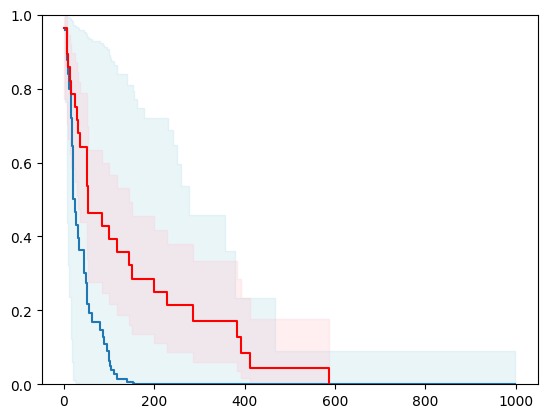

In [37]:
import xgboost as xgb

X, y = load_veterans_lung_cancer()
X = _encode_categorical_columns(X)

# Create a new structured array with Survival_in_days as float32
new_dtype = [('Status', '?'), ('Survival_in_days', '<f4')]
y_converted = np.array(y.tolist(), dtype=new_dtype)

X_train, X_test, y_train, y_test = train_test_split(X, y_converted,
                                                    test_size=0.2,
                                                    random_state=4)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PISurvivalCustom(regr=xgb.XGBRegressor(),
                             type_pi="kde")

estimator.fit(X_train, y_train)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

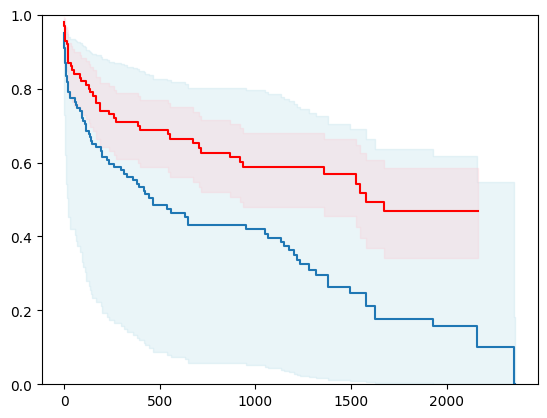

In [38]:
X, y = load_whas500()
X = _encode_categorical_columns(X)

# Create a new structured array with Survival_in_days as float32
new_dtype = [('Status', '?'), ('Survival_in_days', '<f4')]
y_converted = np.array(y.tolist(), dtype=new_dtype)

X_train, X_test, y_train, y_test = train_test_split(X, y_converted,
                                                    test_size=0.2,
                                                    random_state=4)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PISurvivalCustom(regr=xgb.XGBRegressor(),
                             type_pi="kde")

estimator.fit(X_train, y_train)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

# 7 - using `lightgbm`

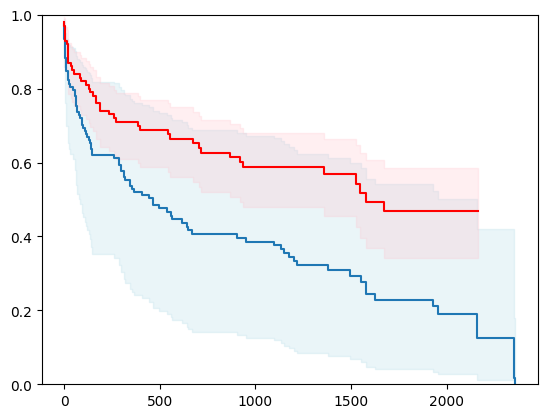

In [39]:
import lightgbm as lgb

# Create a new structured array with Survival_in_days as float32
new_dtype = [('Status', '?'), ('Survival_in_days', '<f4')]
y_converted = np.array(y.tolist(), dtype=new_dtype)

X_train, X_test, y_train, y_test = train_test_split(X, y_converted,
                                                    test_size=0.2,
                                                    random_state=4)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PISurvivalCustom(regr=lgb.LGBMRegressor(verbose=-1,
                                                    random_state=42),
                             type_pi="kde")

estimator.fit(X_train, y_train)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

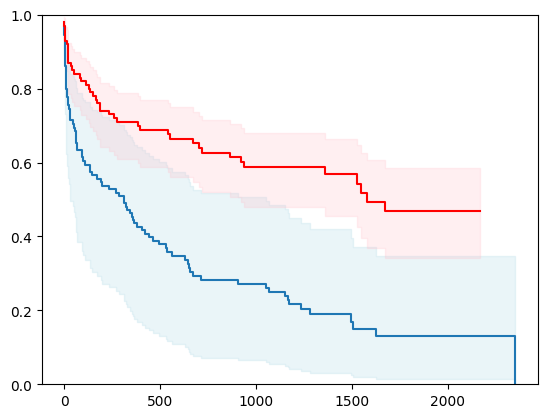

In [40]:
X, y = load_whas500()
X = _encode_categorical_columns(X)

# Create a new structured array with Survival_in_days as float32
new_dtype = [('Status', '?'), ('Survival_in_days', '<f4')]
y_converted = np.array(y.tolist(), dtype=new_dtype)

X_train, X_test, y_train, y_test = train_test_split(X, y_converted,
                                                    test_size=0.2,
                                                    random_state=4)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PISurvivalCustom(regr=lgb.LGBMRegressor(verbose=-1,
                                                    random_state=42),
                             type_pi="kde")

estimator.fit(X_train, y_train)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

# 8 - using Generic Boosting (`mlsauce`)

In [41]:
import mlsauce as ms

Could not import RollingOriginForecaster: No module named 'rollingorigin'


In [42]:
regr_ridge = ms.GenericBoostingRegressor(ms.RidgeRegressor(reg_lambda=1e3),
                                         verbose=0)


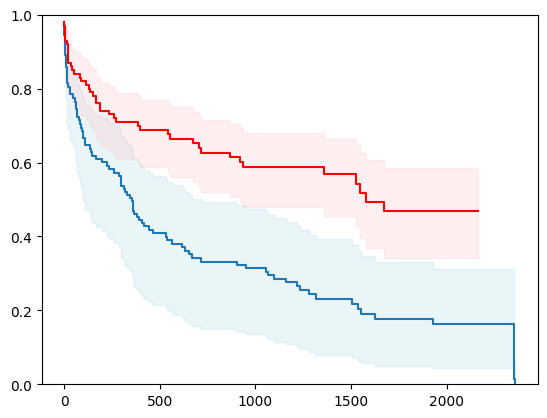

In [43]:
# Create a new structured array with Survival_in_days as float32
new_dtype = [('Status', '?'), ('Survival_in_days', '<f4')]
y_converted = np.array(y.tolist(), dtype=new_dtype)

X_train, X_test, y_train, y_test = train_test_split(X, y_converted,
                                                    test_size=0.2,
                                                    random_state=4)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PISurvivalCustom(regr=regr_ridge,
                             type_pi="kde")

estimator.fit(X_train, y_train)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

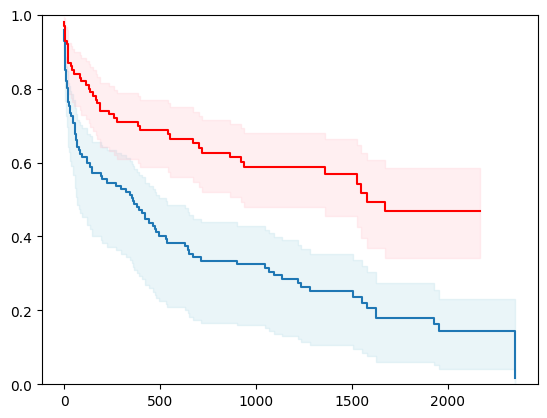

In [44]:
X, y = load_whas500()
X = _encode_categorical_columns(X)

# Create a new structured array with Survival_in_days as float32
new_dtype = [('Status', '?'), ('Survival_in_days', '<f4')]
y_converted = np.array(y.tolist(), dtype=new_dtype)

X_train, X_test, y_train, y_test = train_test_split(X, y_converted,
                                                    test_size=0.2,
                                                    random_state=4)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PISurvivalCustom(regr=regr_ridge,
                             type_pi="kde")

estimator.fit(X_train, y_train)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()